# Monitor performance

## Setup

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import requests
from datetime import datetime, timedelta

import pymysql

from sklearn.metrics import mean_squared_error

# email
import smtplib
import ssl
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart

## Hyperparameter

In [32]:
# mysql
HOST = 'ENDPOINT'
USER = 'USER'
PASSWORD = 'PASSWORD'
PORT = 3306
DB = 'DB'
DATE = (datetime.now() - timedelta(days = 7)).strftime('%Y-%m-%d')
print(DATE)

# eia
URL_EIA_01 = 'http://api.eia.gov/series/?api_key='
URL_EIA_02 = '&series_id='
API_KEY = 'API_KEY'
SERIES_ID = 'EBA.PSCO-ALL.D.H'
NAME = 'load'

# analysis
PATH_SAVEFIG_01 = '/home/ubuntu/github/airflow-automation/01_notebooks/psco_monitoring_01.png'
PATH_SAVEFIG_02 = '/home/ubuntu/github/airflow-automation/01_notebooks/psco_monitoring_02.png'
PATH_EVALUATION = '/home/ubuntu/github/airflow-automation/01_notebooks/psco_evaluation.pkl'

# email
PORT_EMAIL = 465
PASSWORD_EMAIL = 'EMAIL_PASSWORD'
SENDER_EMAIL = 'EMAIL_ADDRESS'
RECEIVER_EMAIL = 'EMAIL_ADDRESS'

plt.style.use('default')

2020-07-18


## Function

In [33]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

## Forecast load

In [34]:
# connection
connection = pymysql.connect(host=HOST, user=USER, password=PASSWORD, port=PORT, db=DB)

# query
query = """
SELECT
  *
FROM
  jupyterdb.psco_load_forecast
WHERE
  validity_index >= '{}'
""".format(DATE)

df = pd.read_sql(query, con = connection)

# drop duplicate
df = df.sort_values(by = ['created_at', 'validity_index'], ascending = [False, False])
print(df.shape)
df = df.drop_duplicates(subset = 'validity_index', keep = 'first')
print(df.shape)
df = df.set_index('validity_index').sort_index()

df_f = df.copy()

(222, 9)
(142, 9)


In [35]:
df_f.head(2)

,temp_f,year,month,day,hour,dow,forecast_load,created_at
validity_index,,,,,,,,
2020-07-21 21:00:00,70.911567,2020,7,21,21,1,6955.477539,2020-07-22 03:13:15
2020-07-21 22:00:00,68.853641,2020,7,21,22,1,6940.402344,2020-07-22 03:13:15


In [36]:
df_f.tail(2)

,temp_f,year,month,day,hour,dow,forecast_load,created_at
validity_index,,,,,,,,
2020-07-27 17:00:00,89.511769,2020,7,27,17,0,7794.742188,2020-07-24 20:15:22
2020-07-27 18:00:00,90.083815,2020,7,27,18,0,8012.375000,2020-07-24 20:15:22


## Actual load

In [37]:
url = URL_EIA_01 + API_KEY + URL_EIA_02 + SERIES_ID
print(url)

response = requests.get(url)
print('status_code', response.status_code)

data = response.json()['series'][0]['data']
df = pd.DataFrame(data, columns = ['period', 'value'])
df.index = pd.to_datetime(df['period'])
df = df.sort_index()

df_utc = df.copy()

df = df.tz_convert('America/Denver')
df = df.tz_localize(None)
df = df.loc[~df.index.duplicated(keep = 'first')]
df = df.rename(columns = {'value': NAME})
df = df.drop('period', axis = 1)
df = df.sort_index()

df_load = df.copy()

http://api.eia.gov/series/?api_key=1f251657d4404b4115a5d852206cceb1&series_id=EBA.PSCO-ALL.D.H
status_code 200


In [38]:
df_load.head(2)

,load
period,
2015-07-01 01:00:00,4875.0
2015-07-01 02:00:00,4618.0


In [39]:
df_load.tail(2)

,load
period,
2020-07-24 19:00:00,7365.0
2020-07-24 20:00:00,7110.0


## Performance data

In [40]:
df_per = df_f.copy()
df_per['actual_load'] = df_load['load']
df_per['error'] = df_per['actual_load'] - df_per['forecast_load']
df_per['percent_error'] = (df_per['actual_load'] - df_per['forecast_load']) / df_per['actual_load']
df_per['abs_percent_error'] = np.abs(df_per['percent_error'])
df_per = df_per.dropna()

In [41]:
df_per.head()

,temp_f,year,month,day,hour,dow,forecast_load,created_at,actual_load,error,percent_error,abs_percent_error
validity_index,,,,,,,,,,,,
2020-07-21 21:00:00,70.911567,2020,7,21,21,1,6955.477539,2020-07-22 03:13:15,7395.0,439.522461,0.059435,0.059435
2020-07-21 22:00:00,68.853641,2020,7,21,22,1,6940.402344,2020-07-22 03:13:15,7073.0,132.597656,0.018747,0.018747
2020-07-21 23:00:00,66.208548,2020,7,21,23,1,6540.458496,2020-07-22 03:13:15,6456.0,-84.458496,-0.013082,0.013082
2020-07-22 00:00:00,64.560992,2020,7,22,0,2,5243.111328,2020-07-22 03:13:15,5826.0,582.888672,0.100050,0.100050
2020-07-22 01:00:00,58.096721,2020,7,22,1,2,4840.948730,2020-07-22 03:13:15,5386.0,545.051270,0.101198,0.101198


In [42]:
df_per.tail()

,temp_f,year,month,day,hour,dow,forecast_load,created_at,actual_load,error,percent_error,abs_percent_error
validity_index,,,,,,,,,,,,
2020-07-24 16:00:00,70.412667,2020,7,24,16,4,6166.557617,2020-07-24 20:15:22,8073.0,1906.442383,0.236150,0.236150
2020-07-24 17:00:00,62.388814,2020,7,24,17,4,5928.191895,2020-07-24 20:15:22,7847.0,1918.808105,0.244528,0.244528
2020-07-24 18:00:00,64.440848,2020,7,24,18,4,5981.309082,2020-07-24 20:15:22,7604.0,1622.690918,0.213400,0.213400
2020-07-24 19:00:00,65.487751,2020,7,24,19,4,6095.524414,2020-07-24 20:15:22,7365.0,1269.475586,0.172366,0.172366
2020-07-24 20:00:00,66.779615,2020,7,24,20,4,6294.172852,2020-07-24 20:15:22,7110.0,815.827148,0.114744,0.114744


## Visualize

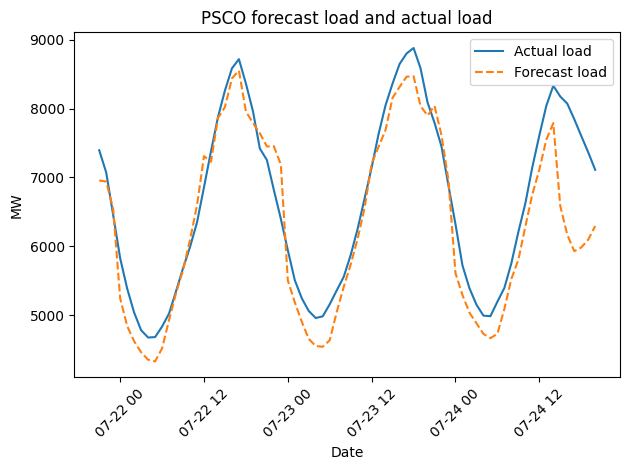

In [43]:
plt.plot(df_per['actual_load'], label = 'Actual load')
plt.plot(df_per['forecast_load'], linestyle = '--', label = 'Forecast load')
plt.title('PSCO forecast load and actual load')
plt.xlabel('Date')
plt.ylabel('MW')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.savefig(PATH_SAVEFIG_01)
plt.show()

## Evaluation

In [44]:
mape = mean_absolute_percentage_error(df_per['actual_load'], df_per['forecast_load'])
rmse = np.sqrt(mean_squared_error(df_per['actual_load'], df_per['forecast_load']))

print('MAPE: {:,.1%}'.format(mape))
print('RMSE: {:,.1f}MW'.format(rmse))

MAPE: 6.2%
RMSE: 565.4MW


## Save evaluation

In [45]:
# print(type(mape), type(rmse))
evaluation = [mape, rmse]
pickle.dump(evaluation, open(PATH_EVALUATION, 'wb'))

## Hourly forecast error

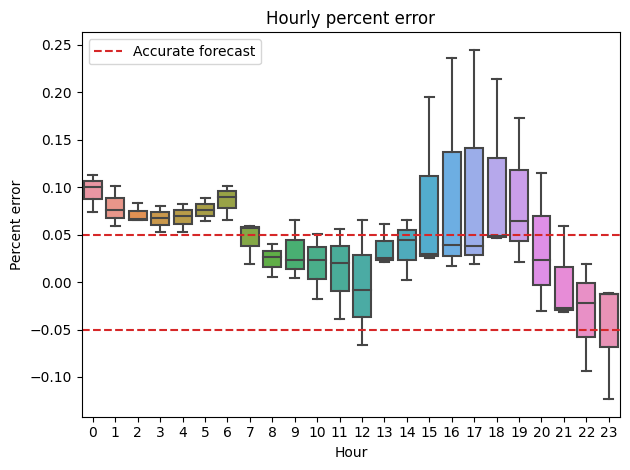

In [46]:
sns.boxplot(df_per.index.hour, df_per['percent_error'])
plt.axhline(y = 0.05, linestyle = '--', color = '#d62728', label = 'Accurate forecast')
plt.axhline(y = -0.05, linestyle = '--', color = '#d62728')
plt.title('Hourly percent error')
plt.xlabel('Hour')
plt.ylabel('Percent error')
plt.legend()
plt.tight_layout()
plt.savefig(PATH_SAVEFIG_02)
plt.show()

## Email subject

In [47]:
subject = df_per.index[0].strftime('%b%d') + '-' + \
          df_per.index[-1].strftime('%b%d') + \
          ' PSCO short term load forecast monitoring'

print(subject)

Jul21-Jul24 PSCO short term load forecast monitoring


## Email contents

In [48]:
html = """
<html>
  <p>MAPE: {:,.1%}, RMSE: {:,.1f}MW</p>
  <img src="cid:{}">
  <img src="cid:{}">
  <p>Sincerely,</p>
  <p>Yuki</p>
</html>
""".format(mape, rmse,
           PATH_SAVEFIG_01,
           PATH_SAVEFIG_02)

print(html)


<html>
  <p>MAPE: 6.2%, RMSE: 565.4MW</p>
  <img src="cid:/home/ubuntu/psco/psco_monitoring_01.png">
  <img src="cid:/home/ubuntu/psco/psco_monitoring_02.png">
  <p>Sincerely,</p>
  <p>Yuki</p>
</html>



## Send email

In [49]:
# make message
msg = MIMEMultipart()
msg['Subject'] = subject
msg['From'] = SENDER_EMAIL
msg['To'] = RECEIVER_EMAIL

# content
msgText = MIMEText(html, 'html')
msg.attach(msgText)

# images
f = open(PATH_SAVEFIG_01, 'rb')
msgImage = MIMEImage(f.read())
f.close()
msgImage.add_header('Content-ID', '<{}>'.format(PATH_SAVEFIG_01))
msg.attach(msgImage)
f = open(PATH_SAVEFIG_02, 'rb')
msgImage = MIMEImage(f.read())
f.close()
msgImage.add_header('Content-ID', '<{}>'.format(PATH_SAVEFIG_02))
msg.attach(msgImage)

# send email
context = ssl.create_default_context()
with smtplib.SMTP_SSL('smtp.gmail.com', PORT_EMAIL, context = context) as server:
    server.login(SENDER_EMAIL, PASSWORD_EMAIL)
    server.sendmail(SENDER_EMAIL, RECEIVER_EMAIL, msg.as_string())

## Automation timestamp

In [50]:
print(datetime.now())

2020-07-25 03:11:24.161915
